# Classification Workflow with Pipelines

Let's add pipelines into our workflow!

In [56]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.tree import DecisionTreeClassifier

## Bringing in Our Modeling Class from before

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [3]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
X = titanic.drop(['PassengerId', 'Name', 'Survived'], axis=1)
y = titanic['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Using `Pipeline` and `ColumnTransformer`

When we use the `ColumnTransformer` we'll want to choose the relevant column numbers, so let's remind ourselves which columns are where:

In [5]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,female,35.0,1,0,113803,53.1000,C123,S
4,3,male,35.0,0,0,373450,8.0500,NaN,S


In [95]:
# We'll throw these mini-pipelines into our ColumnTransformer: numeric and categorical
subpipe_numerics = Pipeline(steps=[
    ('num_impute', SimpleImputer(add_indicator=True)),
    #('poly', PolynomialFeatures()),
    ('ss', StandardScaler()),
])

# strings are names of the steps, have to have a name for the step, can be called anything

sub_pipe_cat = Pipeline(steps=[
    
    ('cat_impute', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
# Verbose set to True is good for debugging, shows steps if they break

### Selector!!!!

[This](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_selector.html#sklearn.compose.make_column_selector) will return a callable list of columns

In [58]:
# Selector!

test = selector(dtype_include=object)

In [59]:
test(X)

['Sex', 'Ticket', 'Cabin', 'Embarked']

In [60]:
numtest = selector(dtype_include=np.number)

In [61]:
numtest(X)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [62]:
CT = ColumnTransformer(transformers=[
    ('subpipe_num', subpipe_numerics, selector(dtype_include=np.number)),
    ('subpipe_cat', sub_pipe_cat, selector(dtype_include=object))
], remainder='passthrough')

# if we had DIFFERENT DATA TYPES, we need to set remainder argument
# np.number is a catchall for ANYTHING numeric
# takes a bunch of transformers and does the transformation

# args are: name, transformer, 

In [63]:
# The "remainder='passthrough'" bit tells the compiler to leave
# the other df columns unchanged.


In [64]:
# The `ColumnTransformer` will take care of our preprocessing,
# so now we can add our model at the end of the pipeline.


In [65]:
# Create Dummy/Baseline

dummy_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('dummy', DummyClassifier(strategy='most_frequent'))
])
# this is now our estimator

In [66]:
# Use the class with out dummy pipe

dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4edf20df0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                            

In [67]:
dummy_model_pipe.score(X_train, y_train)

0.6212574850299402

In [68]:
dummy_model_pipe.score(X_test, y_test)

0.600896860986547

In [69]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe, 
    model_name='dummy',
    X=X_test,
    y=y_test,
)

CV Results for `dummy` model:
            0.60079 ± 0.01428 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

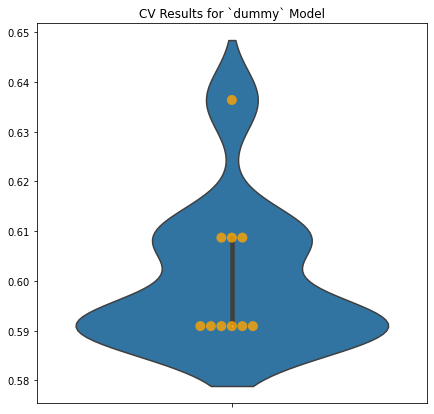

In [70]:
fig, ax = plt.subplots(figsize=(7,7))

dummy_pipe.print_cv_summary()

dummy_pipe.plot_cv(ax=ax)

In [71]:
fsm_model_pipe = Pipeline(steps=[
    ('ct', CT),
    ('fsm', 
])

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' on line 3 (<ipython-input-71-d321220b2b56>, line 4)

In [ ]:
fsm_model_pipe = Pipeline(steps=[
    ('ct',CT),
    ('fsm',LogisticRegression())
])
# Use the class with out logreg pipe
fsm_pipe = ModelWithCV(
    fsm_model_pipe,
    model_name='fsm',
    X=X_test,
    y=y_test,
)

fig, ax = plt.subplots()

fsm_pipe.print_cv_summary()
fsm_pipe.plot_cv(ax=ax)

In [72]:
dum_model = DummyClassifier(strategy='most_frequent')
lr_model = LogisticRegression()
tree_model = DecisionTreeClassifier()
# gbc_model = GradientBoostingClassifier()

In [73]:
model_list = [('dummy', dum_model), ('logreg', lr_model), ('dtc', tree_model)]

In [74]:
for name, model in model_list:
    loop_model_pipe = Pipeline(steps=[
        ('ct', CT),
        (name, model)
    ])
    
    loop_model_pipe.fit(X_train,y_train)
    
    loop_pipe = ModelWithCV(
        loop_model_pipe,
        model_name=name,
        X=X_test,
        y=y_test)
    
    loop_pipe.print_cv_summary()

CV Results for `dummy` model:
            0.60079 ± 0.01428 accuracy
        


/Users/samalainabayeva/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CV Results for `logreg` model:
            0.82075 ± 0.08332 accuracy
        
CV Results for `dtc` model:
            0.80237 ± 0.04629 accuracy
        


In [75]:
fsm_model_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'ct', 'fsm', 'ct__n_jobs', 'ct__remainder', 'ct__sparse_threshold', 'ct__transformer_weights', 'ct__transformers', 'ct__verbose', 'ct__subpipe_num', 'ct__subpipe_cat', 'ct__subpipe_num__memory', 'ct__subpipe_num__steps', 'ct__subpipe_num__verbose', 'ct__subpipe_num__num_impute', 'ct__subpipe_num__ss', 'ct__subpipe_num__num_impute__add_indicator', 'ct__subpipe_num__num_impute__copy', 'ct__subpipe_num__num_impute__fill_value', 'ct__subpipe_num__num_impute__missing_values', 'ct__subpipe_num__num_impute__strategy', 'ct__subpipe_num__num_impute__verbose', 'ct__subpipe_num__ss__copy', 'ct__subpipe_num__ss__with_mean', 'ct__subpipe_num__ss__with_std', 'ct__subpipe_cat__memory', 'ct__subpipe_cat__steps', 'ct__subpipe_cat__verbose', 'ct__subpipe_cat__cat_impute', 'ct__subpipe_cat__ohe', 'ct__subpipe_cat__cat_impute__add_indicator', 'ct__subpipe_cat__cat_impute__copy', 'ct__subpipe_cat__cat_impute__fill_value', 'ct__subpipe_cat__cat_impute__missing_values

In [79]:
params = {
    'ct__subpipe_num__num_impute__strategy' : ['mean','median'],
    'ct__subpipe_num__poly__degree' :[1,2,3],
    'fsm__solver' : ['liblinear','lbfgs'],
    'fsm__max_iter': [10, 100,1000,10_000],
    'fsm__C' : [0.0001, 0.001, 0.01, 0.1, 1],
    'fsm__tol' : [0.0001, 0.001, 0.01, 0.1]
}

In [80]:
gs = GridSearchCV(
    estimator= fsm_model_pipe,
    param_grid=params,
    cv=5,
    verbose=1)

In [81]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Invalid parameter poly for estimator Pipeline(steps=[('num_impute', SimpleImputer()), ('ss', StandardScaler())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [36]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'mean',
 'fsm__C': 1,
 'fsm__max_iter': 10,
 'fsm__solver': 'liblinear',
 'fsm__tol': 0.0001}

In [39]:
gs_best = gs.best_estimator_

# if you have cells that take a long time to run, comment them out, but 
# show your work somewhere later in the notebook

CV Results for `gs` model:
            0.82470 ± 0.07831 accuracy
        


<AxesSubplot:title={'center':'CV Results for `gs` Model'}>

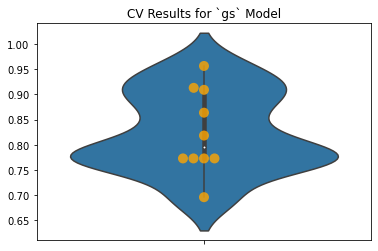

In [40]:
gs_pipe = ModelWithCV(
    gs_best,
    model_name='gs',
    X=X_test,
    y=y_test
)

fig, ax = plt.subplots()

gs_pipe.print_cv_summary()

gs_pipe.plot_cv(ax=ax)

In [41]:
gs_best.score(X_train, y_train)

0.8817365269461078

In [42]:
gs_best.score(X_test, y_test)

0.8295964125560538

In [31]:
# Create FSM (First Simple Model)

In [32]:
# Use the class with out logreg pipe


## Trying Other Models at the End of the Pipeline

Can I have multiple models in a single pipeline? Yes. We'll forgo this here, but for more on this see [here](https://stackoverflow.com/questions/48507651/multiple-classification-models-in-a-scikit-pipeline-python).

### Random Forest

In [ ]:
# rfc!

### Gradient Booster

In [ ]:
# gbc!

## Tuning and Cross-Validating

In [ ]:
# GridSearch?

## `imblearn` Pipelines

### Dealing with the Target Imbalance

Let's use `SMOTE()`:

In [96]:
y_train.value_counts()

0    415
1    253
Name: Survived, dtype: int64

In [97]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

In [98]:
sm2 = SMOTE(sampling_strategy=0.8, random_state=42)

To make things simple (and avoid errors!), let's just grab the numeric types and eliminate the NaNs from X_train:

In [99]:
X_train_clean = X_train.select_dtypes(['float', 'int']).dropna()
y_train_clean = y_train[X_train_clean.index]

In [100]:
y_train_clean.value_counts()

0    317
1    219
Name: Survived, dtype: int64

In [101]:
# Even distribution

X_clean_resmp, y_clean_resmp = sm.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp.value_counts()

1    317
0    317
Name: Survived, dtype: int64

In [102]:
# Distribution where count of 1's = 0.8 * count of 0's

X_clean_resmp2, y_clean_resmp2 = sm2.fit_resample(X_train_clean, y_train_clean)

y_clean_resmp2.value_counts()

0    317
1    253
Name: Survived, dtype: int64

### `imblearn` Pipeline

Of course, we want to be able to perform all of our preprocessing steps from above, but just now add `SMOTE`. Good thing we can throw it all into a pipeline!

In [103]:
# there is a different pipeline for imblearn

In [106]:
# imbpipe!

imbpipe = ImPipeline(steps=[
    ('ct', CT),
    ('sm', SMOTE(random_state=42)),
    ('gs_best', LogisticRegression(C=1, max_iter=10, solver='liblinear', tol=.0001))
])

In [107]:
imbpipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(add_indicator=True)),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd4edf20df0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                            

In [108]:
imbpipe.score(X_train, y_train)

0.8877245508982036

In [109]:
imbpipe.score(X_test, y_test)

0.820627802690583

### Gridsearching

In [ ]:
# Seriously? Again?

## Evaluation on Test Set

Let's suppose that we choose our final model from this last GridSearch run. Note that the optimal parameters are also the default values!

In [111]:
final_model = imbpipe

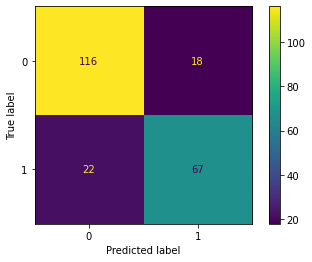

In [112]:
plot_confusion_matrix(final_model, X_test, y_test);

In [113]:
y_hat = final_model.predict(X_test)

In [114]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.82. 

Our final model's recall on the test set is 0.75 

Our final model's precision on the test set is 0.79 

Our final model's f1-score on the test is 0.77.



## Exercise: Your Turn!

Use SMOTE and an estimator (model) of your choice in a pipeline to model the exoplanets' method of discovery ("method"). You can build a model one feature at a time or just throw them all in from the beginning. Consider using the LabelEncoder (from sklearn.preprocessing) to code up the target. You'll also need to make a choice about how to handle the null values.

In [ ]:
exos = sns.load_dataset('planets')

In [ ]:
### Your work here






